In [2]:
import ccxt
import pandas as pd

# 初始化交易所
# 初始化 Binance 交易所，配置代理和顶级域名
exchange = ccxt.binance({
    'httpsProxy': 'http://127.0.0.1:7890',  # 设置代理
    'timeout': 30000,  # 请求超时时间（可选）
    'tld': 'us',  # Binance US 域名
    'rateLimit': 1200,
    'enableRateLimit': True,
})

Fetching data for AAVE/USDT...
Error fetching data for AAVE/USDT: binance GET https://fapi.binance.com/fapi/v1/exchangeInfo
Fetching data for DOT/USDT...
Fetching data for DOGE/USDT...
Fetching data for ARB/USDT...
Fetching data for AVAX/USDT...
Fetching data for LINK/USDT...
Fetching data for TON/USDT...
Fetching data for SOL/USDT...
Fetching data for DYDX/USDT...
Fetching data for SUI/USDT...
Fetching data for BNB/USDT...
Fetching data for LTC/USDT...
Fetching data for ORDI/USDT...
Fetching data for FET/USDT...
Fetching data for TRX/USDT...
Fetching data for UNI/USDT...
Fetching data for 1000PEPE/USDT...
Fetching data for 1000SHIB/USDT...
Fetching data for ALGO/USDT...
Fetching data for ETH/USDT...
Fetching data for BTC/USDT...
Fetching data for XMR/USDT...
Fetching data for TICP/USDT...
Error fetching data for TICP/USDT: binance does not have market symbol TICP/USDT
Fetching data for OP/USDT...
Fetching data for APT/USDT...
Fetching data for KAS/USDT...
Fetching data for ADA/USDT...

C:\Users\youlong\AppData\Local\Temp\ipykernel_20452\1021002141.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


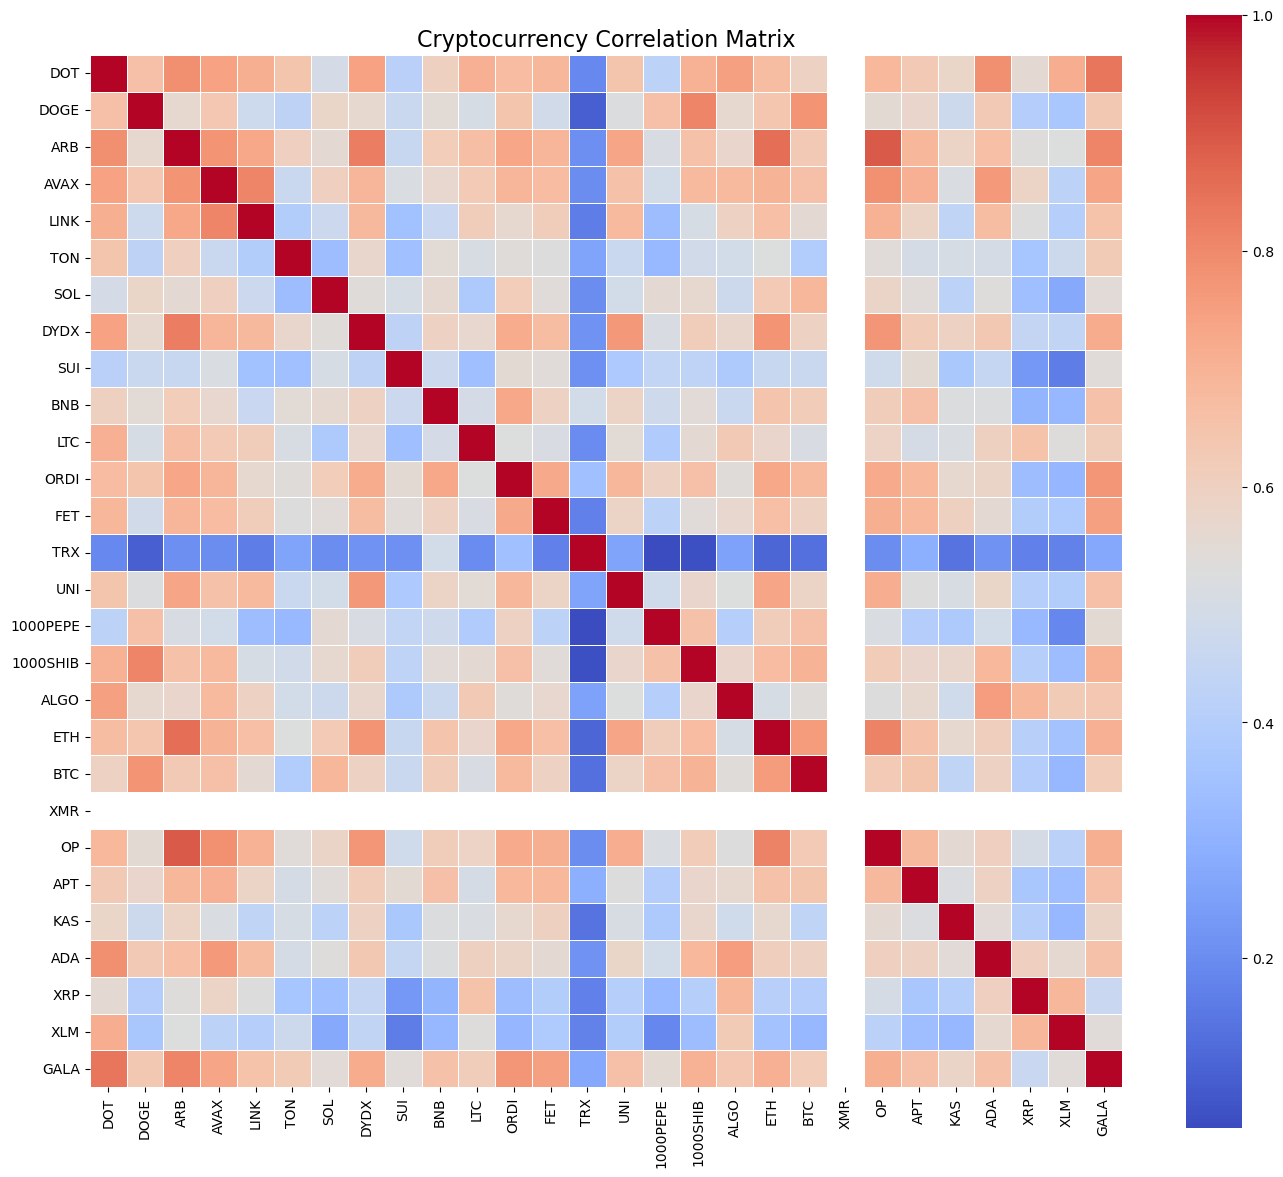

In [5]:
import ccxt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


# 目标加密货币交易对列表
cryptos = ['AAVE/USDT', 'DOT/USDT', 'DOGE/USDT', 'ARB/USDT', 'AVAX/USDT', 'LINK/USDT', 
           'TON/USDT', 'SOL/USDT', 'DYDX/USDT', 'SUI/USDT', 'BNB/USDT', 'LTC/USDT', 
           'ORDI/USDT', 'FET/USDT', 'TRX/USDT', 'UNI/USDT', '1000PEPE/USDT', 
           '1000SHIB/USDT', 'ALGO/USDT', 'ETH/USDT', 'BTC/USDT', 'XMR/USDT', 
           'TICP/USDT', 'OP/USDT', 'APT/USDT', 'KAS/USDT', 'ADA/USDT', 
           'XRP/USDT', 'XLM/USDT', 'GALA/USDT']

# 时间范围设置（例如，过去一年的数据）
since = exchange.parse8601('2024-01-01T00:00:00Z')  # 开始时间
timeframe = '1d'  # 时间间隔 (每日数据)

# 获取历史数据的函数
def fetch_ohlcv(symbol, since, timeframe):
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df[['close']]  # 只保留收盘价
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# 下载所有交易对的数据并合并
data_frames = {}
for crypto in cryptos:
    print(f"Fetching data for {crypto}...")
    df = fetch_ohlcv(crypto, since, timeframe)
    if df is not None:
        data_frames[crypto] = df.rename(columns={'close': crypto.split('/')[0]})

# 合并所有交易对的收盘价数据
merged_data = pd.concat(data_frames.values(), axis=1)

# 填充缺失值（例如，前向填充）
merged_data.fillna(method='ffill', inplace=True)
merged_data.dropna(inplace=True)
merged_data.to_csv('all_data.csv')
# 计算每日收益率
returns = np.log(merged_data / merged_data.shift(1)).dropna()

# 计算相关性矩阵
correlation_matrix = returns.corr()

# 绘制相关性矩阵热力图
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True, square=True,
            linewidths=0.5, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.title('Cryptocurrency Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


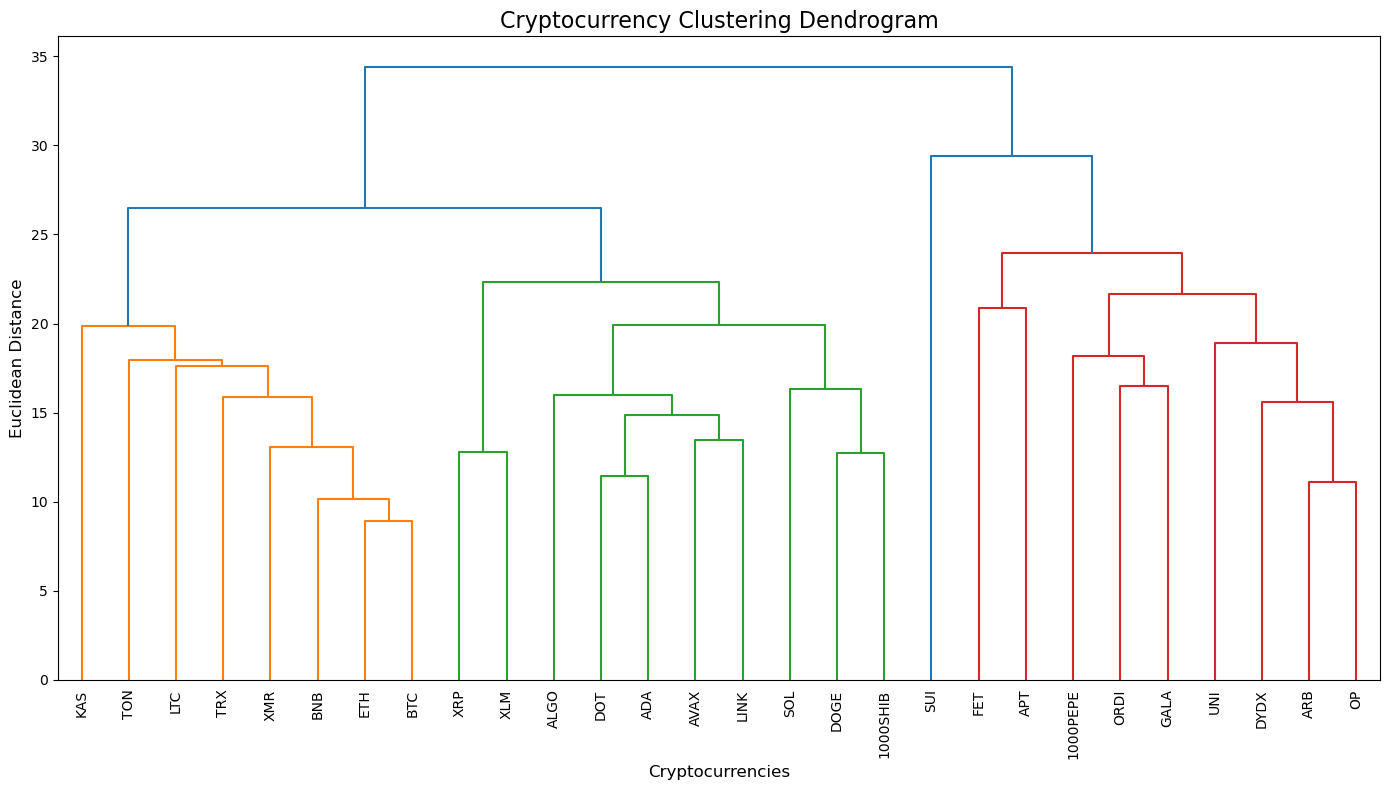


Cryptocurrency Classification Table:
   Cryptocurrency  Cluster
13            TRX        1
23            KAS        1
20            XMR        1
5             TON        1
19            BTC        1
18            ETH        1
9             BNB        1
10            LTC        1
25            XRP        2
24            ADA        2
17           ALGO        2
16       1000SHIB        2
26            XLM        2
0             DOT        2
6             SOL        2
4            LINK        2
3            AVAX        2
1            DOGE        2
14            UNI        3
15       1000PEPE        3
11           ORDI        3
7            DYDX        3
21             OP        3
22            APT        3
2             ARB        3
12            FET        3
27           GALA        3
8             SUI        4


In [6]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 假设已计算出每日收益率数据 (returns)
# returns: 行为日期，列为加密货币，值为每日对数收益率

# 标准化每日收益率数据
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns.T)  # 转置后以加密货币为对象进行聚类

# 计算层次聚类的连接矩阵
linkage_matrix = linkage(scaled_returns, method='ward', metric='euclidean')

# 绘制树状图 (Dendrogram)
plt.figure(figsize=(14, 8))
dendrogram(
    linkage_matrix,
    labels=returns.columns,  # 加密货币名称
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # 设置颜色阈值
)
plt.title('Cryptocurrency Clustering Dendrogram', fontsize=16)
plt.xlabel('Cryptocurrencies', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.tight_layout()
plt.show()

# 根据距离对加密货币进行分组 (例如分成4组)
cluster_labels = fcluster(linkage_matrix, t=4, criterion='maxclust')

# 创建分类表
classification_table = pd.DataFrame({
    'Cryptocurrency': returns.columns,
    'Cluster': cluster_labels
}).sort_values(by='Cluster')

print("\nCryptocurrency Classification Table:")
print(classification_table)


C:\Users\youlong\MiniConda3\envs\ArbitrageTest\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


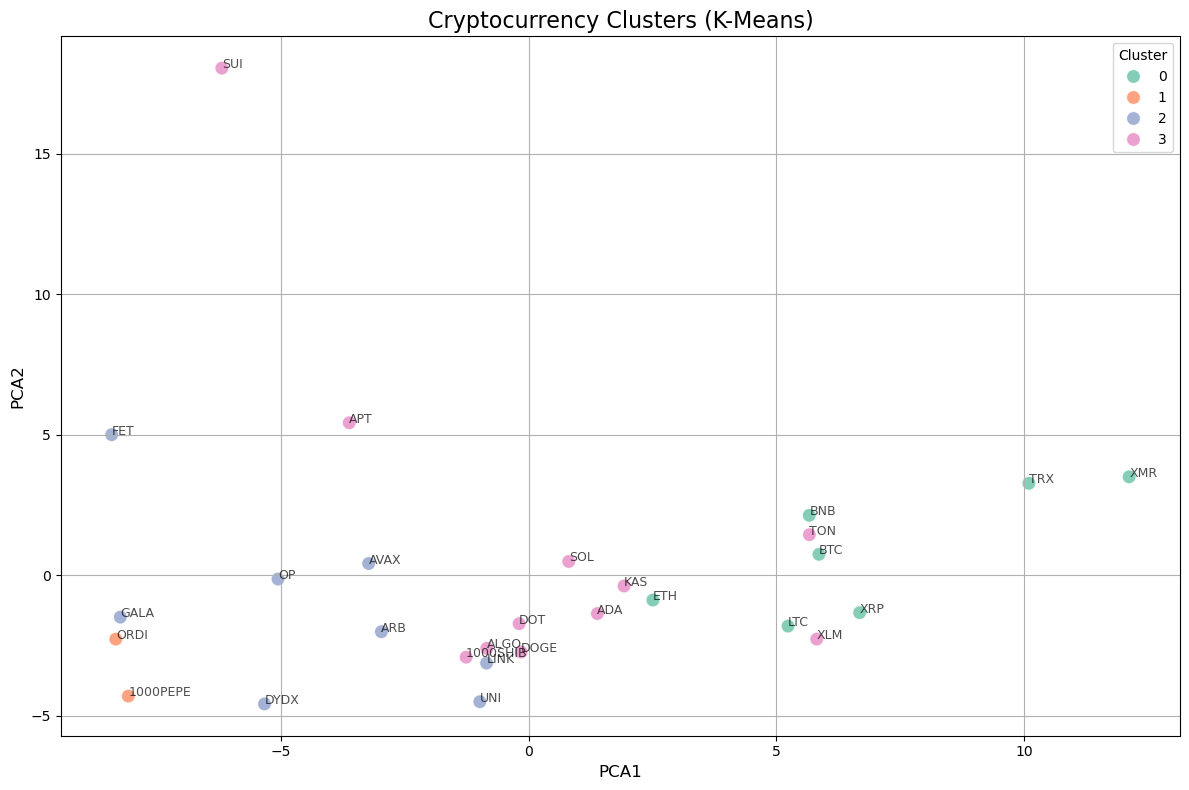

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 假设已计算出每日收益率数据 (returns)
# returns: 行为日期，列为加密货币，值为每日对数收益率

# 数据标准化
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns.T)  # 转置后以加密货币为对象进行聚类

# 使用 K-Means 聚类 (选择 k=4，代表分4类)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_returns)

# 使用 PCA 将数据降维到2D
pca = PCA(n_components=2)
pca_returns = pca.fit_transform(scaled_returns)

# 创建聚类结果的 DataFrame
cluster_data = pd.DataFrame({
    'PCA1': pca_returns[:, 0],
    'PCA2': pca_returns[:, 1],
    'Cluster': cluster_labels,
    'Cryptocurrency': returns.columns
})

# 绘制聚类结果的二维散点图
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cluster_data,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.8
)

# 添加加密货币标签
for i in range(cluster_data.shape[0]):
    plt.text(
        cluster_data['PCA1'][i],
        cluster_data['PCA2'][i],
        cluster_data['Cryptocurrency'][i],
        fontsize=9,
        alpha=0.7
    )

plt.title('Cryptocurrency Clusters (K-Means)', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
